## AB Tests

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from econml.metalearners import TLearner,SLearner,XLearner
from scipy.stats import ttest_ind,chisquare,chi2_contingency
from statsmodels.stats.power import tt_ind_solve_power
import statsmodels.api as sm

from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,f1_score, roc_auc_score

In [2]:
data1 = pd.read_csv('/dataset_part1_students.csv',delim_whitespace=True)
data2 = pd.read_csv('/dataset_part2_students.csv',delim_whitespace=True)
data3 = pd.read_csv('/дз6/dataset_part3_students.csv',delim_whitespace=True)

### 1. Оценка результатов AB теста

В данном задании вам требуется оценить результаты AB теста. Даны результаты на контрольной и тестовой группе после проведения AB теста.
Помимо показателей целевой переменной, вам даны также несколько фичей, которые являются характеристиками объектов. Даны целевые показатели (y) и принадлежность к целевой группе (W).

</u>Задача:</u>
1. Проверьте подходящую для данных гипотезу о равенстве средних в выборках
2. Каков treatment effect нашего воздействия? (ATE) 
3. Примените известные вам методы оценки ATE с учетом особенностей данных.
4. Проанализируйте, сравните результаты применения различных методов.
5. В явном виде выпишите выводы.

</i>Примечание: предположения о рандомизированном эксперименте нуждаются в проверке - независимость treatment от объектов не гарантирована. Все предположения выписывайте явно.</i> 

Для данной задачи используется dataset:  dataset_part1_students.csv

In [3]:
data1.head()

,y,W,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10
0,-1.459404,0.0,0.986277,0.873392,0.509746,0.271836,0.336919,0.216954,0.276477,0.343316,0.862159,0.156700
1,-1.694174,0.0,0.140887,0.757080,0.736325,0.355663,0.341093,0.666803,0.217101,0.561427,0.124179,0.319736
2,5.378374,0.0,0.953214,0.137357,0.569413,0.975665,0.503367,0.667664,0.034191,0.456119,0.155851,0.476049
3,2.188189,1.0,0.169702,0.896258,0.373394,0.379693,0.858317,0.646061,0.583462,0.668350,0.177793,0.849248
4,2.862696,1.0,0.442373,0.831468,0.763921,0.919691,0.070573,0.156165,0.636894,0.555696,0.191929,0.425656


Проверим независимость treatment от объектов с помощью кластеризации.

In [4]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(data1.iloc[:,2:])
preds = pd.Series(kmeans.labels_)

In [5]:
print('Accuracy = ',accuracy_score(data1.W,preds),
      '\nF1_score = ',f1_score(data1.W,preds),
      '\nROC AUC  = ',roc_auc_score(data1.W,preds))

Accuracy =  0.49085 
F1_score =  0.5053194073354385 
ROC AUC  =  0.49052117510066323


Как видно, значения метрик говорят о том, что кластеризация не удалась.

Посмотрим на значения характеристик объектов в зависимости от принадлежности их к группам

In [6]:
data1.groupby('W').mean()

,y,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10
W,,,,,,,,,,,
0.0,1.866349,0.39691,0.390728,0.505678,0.499297,0.497471,0.499891,0.496947,0.497261,0.499343,0.499442
1.0,2.266452,0.59806,0.593573,0.497915,0.502627,0.497835,0.502462,0.498642,0.496682,0.500562,0.498393


Средние значения параметров X1 и X2 отличаются в зависимости от групп.

Посмотрим на корреляцию

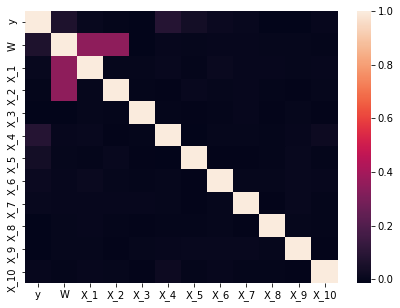

In [7]:
fig = plt.subplots(figsize=(7,5))
sns.heatmap(data1.corr())
plt.show()

Выведем scatterplot значений X_1 и X_2, раскрасив объектры по группам control и treatment

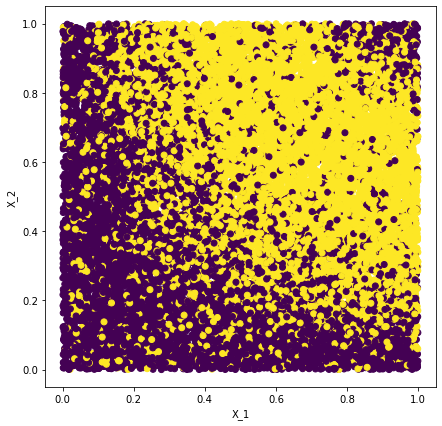

In [8]:
plt.subplots(figsize = (7,7))
plt.scatter(data1['X_1'],data1['X_2'],c=data1['W'])
plt.xlabel('X_1')
plt.ylabel('X_2')
plt.show()

Таким образом, W зависит от X_1 и X_2, то есть полная рандомизированность эксперимента не выполняетcя.

<i>Для дальнейшей работы предположим, что соблюдается условие unconfoundedness.

<i><b>1.Проверьте подходящую для данных гипотезу о равенстве средних в выборках</i>

<i>Нулевая гипотеза - средние равны <br>
Альтернативная - средние не равны

In [9]:
W0 = data1[data1.W==0.0]['y']
W1 = data1[data1.W==1.0]['y']

Посмотрим на распределения

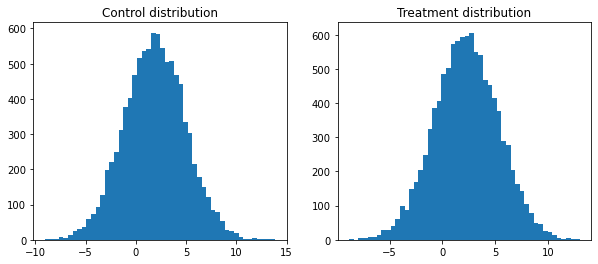

In [10]:
fig,(ax0,ax1) = plt.subplots(1,2,figsize = (10,4))
ax0.hist(W0,bins=50)
ax0.set_title('Control distribution')
ax1.hist(W1,bins=50)
ax1.set_title('Treatment distribution')
plt.show()

Распределение нормальное

В качестве статистического критерия используем t-критерий Стьюдента.<br>$\alpha$ = 0.05.<br>Мощность = 0.8

In [11]:
stat, p = ttest_ind(W0, W1)
print('t-статистика=%.3f \np-value = %.5f' % (stat, p))

t-статистика=-9.332 
p-value = 0.00000


p-value < $\alpha$,<br>отвергаем нулевую гипотезу. Средние не равны

Посчитаем мощность

In [12]:
s_pooled = ((len(W1) - W1.mean()**2 + len(W0) - W0.mean()**2)/(len(W0)+len(W1)-2))**0.5
effect_size = (W1.mean() - W0.mean())/s_pooled
sample_size = len(W0)
alpha=0.05
ratio=len(W1)/len(W0)
statistical_power = tt_ind_solve_power(effect_size=effect_size, nobs1=sample_size, alpha=alpha, ratio=ratio)
print("Статистическая мощность:",statistical_power)

Статистическая мощность: 1.0


Так как мощность > 0.8, критерий состоятельный

<i><b>2.Каков treatment effect нашего воздействия? (ATE)

Допуская, что эксперимент рандомизирован, имеем:

In [13]:
tau_ate = data1[data1.W==1.0]['y'].mean() - data1[data1.W==0.0]['y'].mean()
print('\u03C4_ATE = ',tau_ate)

τ_ATE =  0.40010310554442663


<i><b>3.Примените известные вам методы оценки ATE с учетом особенностей данных.

А. Применим регрессию для оценки treatment effect'a. Для этого предположим, что соблюдается unconfoundedness.

In [14]:
y = data1.y
X = data1.iloc[:,1:]
X = sm.add_constant(X)
model = sm.OLS(y,X)
results = model.fit()

In [15]:
print('\u03C4_ATE regression method = ',results.params['W'])

τ_ATE regression method =  0.5133854882565434


B. ANCOVA

На основе X предскажем значения treatment группы в T=0.

In [16]:
control = data1[data1.W==0]
treat   = data1[data1.W==1]

In [17]:
y_control = control.y
X_control = control.iloc[:,2:]

X_control = sm.add_constant(X_control)
model = sm.OLS(y_control,X_control)
results = model.fit()

In [18]:
X_treat = treat.iloc[:,2:]
X_treat = sm.add_constant(X_treat)
y0_treat = results.predict(X_treat)

In [19]:
y0_control = y_control
y0 = pd.concat((y0_control,y0_treat)).sort_index()

Строим регрессию по формуле с фичами y0 и W

In [20]:
y_ancova = data1.y
X_ancova = pd.concat((y0,data1.W),axis=1)
X_ancova = sm.add_constant(X_ancova)
model = sm.OLS(y_ancova,X_ancova)
results = model.fit()

In [21]:
print('\u03C4_ATE ANCOVA method = ',results.params['W'])

τ_ATE ANCOVA method =  0.5346120187731987


<b>Выводы:

Итак, нащ эксперимент не рандомизирован, но предположив,что выполняется условие unconfoundedness, получили следующие результаты

ATE:<br>
<pre>   Обычная разность средних: 0.4<br></pre>
<pre>   Регрессия на W и X:       0.513<br></pre>
<pre>   ANCOVA:                   0.535<br></pre>

Регрессия и ANCOVA дали более точный результат, так как учли selection bias. Как видно из графика ниже, процент treatment группы в каждом бине по X_1 возрастает с увеличением X_1. (Аналогичное происходит и по фиче X_2)

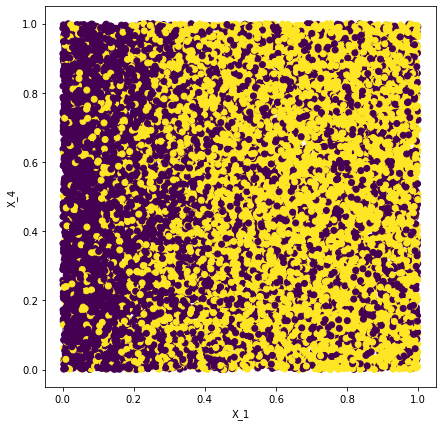

In [22]:
plt.subplots(figsize = (7,7))
plt.scatter(data1['X_1'],data1['X_4'],c=data1['W'])
plt.xlabel('X_1')
plt.ylabel('X_4')
plt.show()

Разобьем выборку по фиче X_1 и оценим среднее значения таргета для treatment группы из двух разбиений.

In [23]:
print('Среднее значение таргета для наблюдений из treatment группы и с X_1>0.8:  ',data1[(data1.X_2>0.75) & data1.W==1].y.mean(),
      '\nСреднее значения таргета для наблюдений из treatment группы и с X_1<0.2:  ',data1[(data1.X_2<0.25) & data1.W==1].y.mean())

Среднее значение таргета для наблюдений из treatment группы и с X_1>0.8:   2.149287207325164 
Среднее значения таргета для наблюдений из treatment группы и с X_1<0.2:   2.2684222039260526


Рассмотрим контрольную группу аналогичным образом

In [24]:
print('Среднее значение таргета для наблюдений из treatment группы и с X_1>0.8: ',data1[(data1.X_2>0.75) & data1.W==0].y.mean(),
      '\nСреднее значения таргета для наблюдений из treatment группы и с X_1<0.2:  ',data1[(data1.X_2<0.25) & data1.W==0].y.mean())

Среднее значение таргета для наблюдений из treatment группы и с X_1>0.8:  2.060675266520377 
Среднее значения таргета для наблюдений из treatment группы и с X_1<0.2:   2.0637810598071


Как видно из результатов выше, selection bias как бы занижает оценку ATE,которую дает метод разности средних, так как процент treatment увеличивается с ростом X_1, но при этом уменьшется значение таргета.

С этой проблемой в некоторой степени справляются регрессионная оценка ATE и ANCOVA, так как они учитывают фичи X

### 2. Оценка результатов AB теста с показателями до начала эксперимента

Необходимо как и ранее оценить результаты AB теста, а именно ATE. Вы располагаете результатами до и после проведения теста (y_0 и y_1), а также вам дан treatment assignment (W). 

Необходимо: 
1. Проверить все требуемые гипотезы
2. Оценить ATE подходящим для этого случая методом (примените несколько методов)
3. Сравнить и проанализировать результаты оценок
4. Явно выписать выводы.

Как и прежде, все предположения должны быть указаны. Визуализация результатов приветствуется.

dataset_part2_students.csv

<i><b>1.Проверить все требуемые гипотезы</i>

In [25]:
data2.head()

,y_1,y_0,W,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10
0,5.887156,2.785060,1.0,0.605978,0.733369,0.138947,0.312673,0.997243,0.128162,0.178993,0.752925,0.662161,0.784310
1,2.232601,5.533515,0.0,0.096894,0.058571,0.962396,0.616557,0.086630,0.561272,0.616525,0.963843,0.574304,0.371161
2,0.144419,0.095546,1.0,0.452145,0.201850,0.569305,0.195096,0.583704,0.476313,0.517814,0.823099,0.732225,0.069056
3,-2.446425,3.590472,1.0,0.672129,0.643485,0.828014,0.204469,0.617489,0.617701,0.301069,0.871741,0.589654,0.981770
4,2.163090,1.365405,0.0,0.442232,0.126318,0.508831,0.431786,0.915940,0.709016,0.890655,0.588886,0.636830,0.342209


Проверим независимость treatment от объектов с помощью кластеризации.

In [26]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(data2.iloc[:,3:])
preds = pd.Series(kmeans.labels_)

print('Accuracy = ',accuracy_score(data2.W,preds),
      '\nF1_score = ',f1_score(data2.W,preds),
      '\nROC AUC  = ',roc_auc_score(data2.W,preds))

Accuracy =  0.495 
F1_score =  0.5032461144993114 
ROC AUC  =  0.4953444736673296


Посмотрим на значения характеристик объектов в зависимости от принадлежности их к группам

In [27]:
data2.groupby('W').mean()

,y_1,y_0,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10
W,,,,,,,,,,,,
0.0,1.878542,0.816187,0.387120,0.400934,0.495181,0.502530,0.497533,0.499039,0.504281,0.503380,0.501267,0.498942
1.0,2.309793,0.692534,0.592249,0.597398,0.501800,0.497781,0.501576,0.494910,0.501227,0.497676,0.503586,0.497798


Данные аналогичны тем, что были в первом задании: смещенное среднее для X1 и X2. Также видно, что среднее значение таргета у treament и control групп в нулевое время отличается

Посмотрим на корреляцию

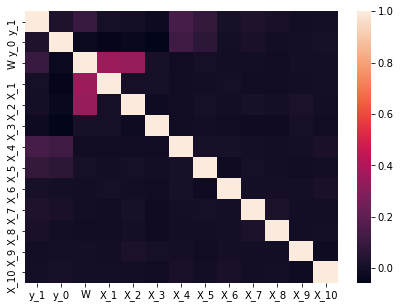

In [28]:
fig = plt.subplots(figsize=(7,5))
sns.heatmap(data2.corr())
plt.show()

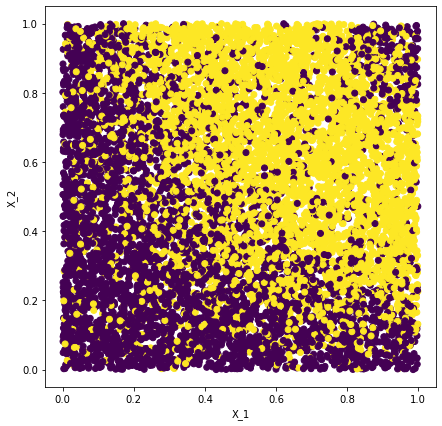

In [29]:
plt.subplots(figsize = (7,7))
plt.scatter(data2['X_1'],data2['X_2'],c=data2['W'])
plt.xlabel('X_1')
plt.ylabel('X_2')
plt.show()

Полная рандомизированность эксперимента не выполняется.

<i>Для дальнейшей работы предположим, что соблюдается условие unconfoundedness.

<i>Нулевая гипотеза - средние равны <br>
Альтернативная - средние не равны

In [30]:
W0 = data2[data2.W==0.0]['y_1']
W1 = data2[data2.W==1.0]['y_1']

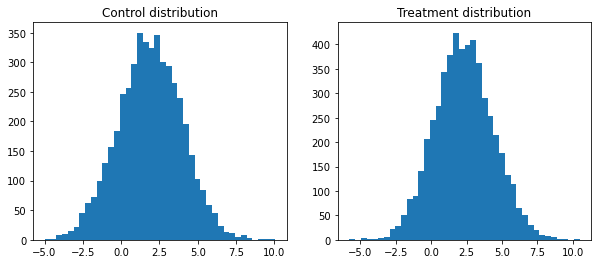

In [31]:
fig,(ax0,ax1) = plt.subplots(1,2,figsize = (10,4))
ax0.hist(W0,bins=40)
ax0.set_title('Control distribution')
ax1.hist(W1,bins=40)
ax1.set_title('Treatment distribution')
plt.show()

Распределение нормальное

В качестве статистического критерия используем t-критерий Стьюдента.<br>$\alpha$ = 0.05.<br>Мощность = 0.8

In [32]:
stat, p = ttest_ind(W0, W1)
print('t-статистика=%.3f \np-value = %.5f' % (stat, p))

t-статистика=-10.434 
p-value = 0.00000


p-value < $\alpha$,<br>отвергаем нулевую гипотезу. Средние не равны

Посчитаем мощность

In [33]:
s_pooled = ((len(W1) - W1.mean()**2 + len(W0) - W0.mean()**2)/(len(W0)+len(W1)-2))**0.5
effect_size = (W1.mean() - W0.mean())/s_pooled
sample_size = len(W0)
alpha=0.05
ratio=len(W1)/len(W0)
statistical_power = tt_ind_solve_power(effect_size=effect_size, nobs1=sample_size, alpha=alpha, ratio=ratio)
print("Статистическая мощность:",statistical_power)

Статистическая мощность: 1.0


Так как мощность > 0.8, критерий состоятельный

<i><b>2.Оценить ATE подходящим для этого случая методом (примените несколько методов)

А. Разность средних

In [34]:
Y_1 = data2[data2.W==1.0]['y_1'].mean() - data2[data2.W==1.0]['y_0'].mean()
Y_0 = data2[data2.W==0.0]['y_1'].mean() - data2[data2.W==0.0]['y_0'].mean()
tau_ate = Y_1-Y_0
print('\u03C4_ATE = ',tau_ate)

τ_ATE =  0.5549047702971193


B. Регрессия

In [35]:
y = data2.y_1 - data2.y_0
X = data2.iloc[:,2:]
X = sm.add_constant(X)
model = sm.OLS(y,X)
results = model.fit()

In [36]:
tau_regr = results.params['W']
print('\u03C4_ATE regression method = ',tau_regr)

τ_ATE regression method =  0.5425071531832343


C. Difference in differences

Составим датасет для метода DiD, отделив исходный датасет по y_1 и y_0, и скливаем полученные части по вертикали

In [37]:
did1 = pd.concat(((data2[['y_0','W']]),pd.Series(np.zeros(10000),name='T')),axis=1).rename(columns={'y_0':'y'})
did2 = pd.concat(((data2[['y_1','W']]),pd.Series(np.ones(10000),name='T')),axis=1).rename(columns={'y_1':'y'})
did  = pd.concat((did1,did2))

In [38]:
did.shape

(20000, 3)

In [39]:
y_did = did.y
X_did = did[['W','T']]
X_did = pd.concat((X_did,np.logical_and(did['W'],did['T']).astype('int')),axis=1).rename(columns={0:'WT'})
X_did = sm.add_constant(X_did)
model = sm.OLS(y_did,X_did)
results = model.fit()

In [40]:
tau_did = results.params['WT']
print('\u03C4_ATE difference in differences = ',tau_did)

τ_ATE difference in differences =  0.5549047702971097


D. CUPED

Посчитаем метрику CUPED

In [41]:
tetta = np.cov(data2.y_1,data2.y_0)[0,1]/np.var(data2.y_0)

In [42]:
cuped = data2.y_1 - (data2.y_0 - data2.y_0.mean())*tetta

Найдем treatment effect методом разности средних на основе CUPED

In [43]:
Y_1_CUPED = cuped[data2.W==1.0].mean() - data2[data2.W==1.0]['y_0'].mean()
Y_0_CUPED = cuped[data2.W==0.0].mean() - data2[data2.W==0.0]['y_0'].mean()
tau_cuped = Y_1_CUPED - Y_0_CUPED
print('\u03C4_ATE CUPED = ',tau_cuped)

τ_ATE CUPED =  0.5578245049261525


Посчитаем АТЕ регрессией на основе CUPED

In [44]:
y = cuped - data2.y_0
X = data2.iloc[:,2:]
X = sm.add_constant(X)
model = sm.OLS(y,X)
results = model.fit()

In [45]:
tau_cuped_regr = results.params['W']
print('\u03C4_ATE CUPED regression = ',tau_cuped_regr)

τ_ATE CUPED regression =  0.5423728847009939


E. ANCOVA

In [46]:
y_ancova = data2.y_1
X_ancova = data2.iloc[:,1:3]
X_ancova = sm.add_constant(X_ancova)
model = sm.OLS(y_ancova,X_ancova)
results = model.fit()

In [47]:
tau_ancova = results.params['W']
print('\u03C4_ATE ANCOVA method = ',tau_ancova)

τ_ATE ANCOVA method =  0.43448638144566665


F. С помощью Propensity score

Для получения propensity score выберем один из алгоритмов предсказания вероятности

In [48]:
bayes = GaussianNB()

X_train = data2.iloc[:,3:]
y_train = data2.W

bayes.fit(X_train,y_train)

y_pred_bayes = bayes.predict_proba(X_train)[:,1]

<i>Оценим АТЕ, применив blocking и регрессию

Blocking.

In [49]:
PS = y_pred_bayes

In [50]:
gr1 = data2[PS>=0.75]
gr2 = data2[(PS>=0.5) & (PS<=0.75)]
gr3 = data2[(PS>=0.25) & (PS<0.5)]
gr4 = data2[PS<0.25]

groups = [gr1,gr2,gr3,gr4]

In [51]:
score = []
for gr in groups:
    Y_1_gr = gr[gr.W==1.0]['y_1'].mean() - gr[gr.W==1.0]['y_0'].mean()
    Y_0_gr = gr[gr.W==0.0]['y_1'].mean() - gr[gr.W==0.0]['y_0'].mean()
    score.append(Y_1_gr - Y_0_gr)
    
tau_ps_blocking = np.array(score).mean()
print('\u03C4_ATE Propensity Score blocking = ',tau_ps_blocking)

τ_ATE Propensity Score blocking =  0.479896160421532


Регрессия.

Добавим наблюдениям веса, в зависимости от их Propensity Score.

In [52]:
y_ps = data2.y_1
y_1 = y[data2.W==1]/(PS[data2.W==1])
y_0 = y[data2.W==0]/(1-(PS[data2.W==0]))
y_ps = pd.concat((y_1,y_0)).sort_index()
y_ps = y_ps - data2.y_0

In [53]:
X_ps = data2.iloc[:,2:]
X_ps = sm.add_constant(X_ps)
model = sm.OLS(y_ps,X_ps)
results = model.fit()

In [54]:
tau_ps_regr = results.params['W']
print('\u03C4_ATE Propensity Score regression = ',tau_ps_regr)

τ_ATE Propensity Score regression =  0.5150699458335165


<b>Выводы:

Итак, наш эксперимент не рандомизированный, но предположив, что выполнено условие unconfoundedness, получаем следующие оценки.

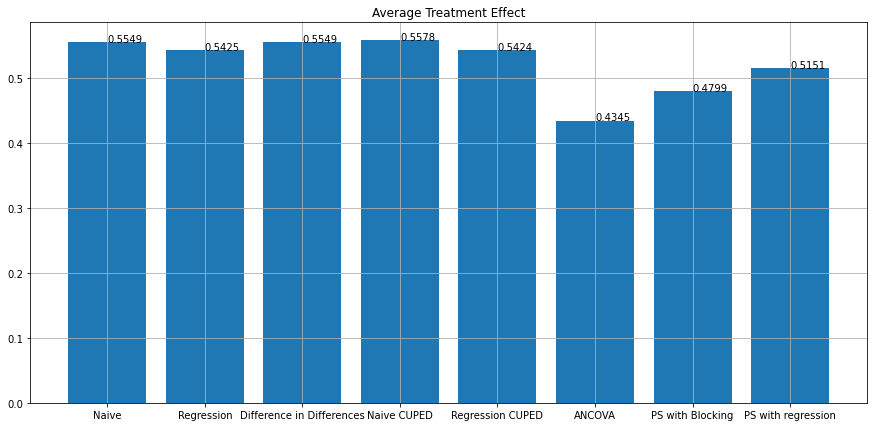

In [55]:
res = np.array([tau_ate,tau_regr,tau_did,tau_cuped,tau_cuped_regr,tau_ancova,tau_ps_blocking,tau_ps_regr])
names = ['Naive','Regression','Difference in Differences','Naive CUPED','Regression CUPED','ANCOVA','PS with Blocking','PS with regression']

fig, ax = plt.subplots(figsize=(15,7))
ax.bar(names, res)
for index, value in enumerate(res):
    plt.text(index,value, str(round(value,4)))
ax.set_title('Average Treatment Effect')
ax.grid()
plt.show()

Оценка Difference in Differences почти не отличается от обычный разности средних, также к этому значению близка оценка разностью средних, но с метрикой CUPED.<br> Регрессия на исходных данных и регрессия на CUPED дают оценку чуть меньше.<br> Использование Propensity Score явно понижает оценку, особенно Blocking.<br> Значительно более низкую оценку дает ANCOVA

Исходные данные аналогичны данным из 1-го задания. То есть у них присутсвует неравномерность распределения групп по X1 и X2, а также значение таргета зависит от X1 и X2( и от других фичей тоже)

In [56]:
print('Среднее значение таргета для наблюдений из treatment группы и с X_1>0.8:  ',data2[(data2.X_2>0.75) & data2.W==1].y_1.mean(),
      '\nСреднее значения таргета для наблюдений из treatment группы и с X_1<0.2:  ',data2[(data2.X_2<0.25) & data2.W==1].y_1.mean())

Среднее значение таргета для наблюдений из treatment группы и с X_1>0.8:   2.2975053262815064 
Среднее значения таргета для наблюдений из treatment группы и с X_1<0.2:   2.4687714516473362


In [57]:
print('Среднее значение таргета для наблюдений из treatment группы и с X_1>0.8:  ',data2[(data2.X_2>0.75) & data2.W==0].y_1.mean(),
      '\nСреднее значения таргета для наблюдений из treatment группы и с X_1<0.2:  ',data2[(data2.X_2<0.25) & data2.W==0].y_1.mean())

Среднее значение таргета для наблюдений из treatment группы и с X_1>0.8:   2.0657158653066405 
Среднее значения таргета для наблюдений из treatment группы и с X_1<0.2:   2.0842127200452425


Данный эскперимент, как уже было показано выше, не является рандомизированным, мы лишь допускаем выполнение unconfoundedness и overlap. Соответственно методы оценки ATE, использующие признаки испытуемых должны,
давать более объективный результат. Как мне кажется, следует отталкиваться от оценки, использующей Propensity Score, так как данный подход учитывает вероятности принадлежности наблюдений к группам на основе их фичей.

### 3. Построение uplift модели по результатам AB теста.

Вам даны результаты AB теста для модели конверсии клиента в продукте (conversion). Конверсия может принимать значения 1 или 0, что значит - клиент подключил услугу, либо не подключил соответственно.

Задача:
1. Оцените ATE по данным.
2. Оцените CATE для каждого наблюдения.
3. Проставьте рекомендации к воздействию на каждый объект.
4. Какая ожидаемая конверсия при оптимальном воздействии?
5. Все выводы, предпосылки и методы представляйте в явном виде в ноутбуке.

Визуализация результатов также будет приветствоваться.

dataset_part3_students.csv

In [58]:
data3 = pd.concat((pd.get_dummies(data3.treatment).treatment,data3.iloc[:,1:]),axis=1).rename(columns={'treatment':'W'})

In [59]:
data3.head()

,W,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,...,X_14,X_15,X_16,X_17,X_18,X_19,X_20,X_21,X_22,conversion
0,0,0.034351,0.550725,-1.348524,-0.029591,0.499535,-0.412464,0.933588,-0.522954,-0.029591,...,-0.314573,-0.879456,0.640264,1.165722,0.570495,0.529443,0.227962,1.929914,0.798664,0
1,0,-1.059404,0.299404,0.220273,-1.569660,1.084204,-2.167118,1.216469,-0.744547,-1.569660,...,0.303664,1.080643,2.646483,-0.329690,1.725636,1.434649,-2.064893,0.188000,-1.134651,0
2,0,0.051934,2.338729,-0.341017,-1.099362,0.693090,-2.424267,1.572066,-0.212798,-1.099362,...,-0.083721,-1.981712,0.224777,2.038004,2.516398,2.324280,-3.182196,-0.888490,-1.402561,0
3,1,0.667770,0.539316,0.468719,-0.840885,-0.708331,0.126634,1.275854,-0.954919,-0.840885,...,-0.752011,-0.347319,-1.659402,-0.871980,-0.893513,-0.658078,-2.704997,-0.390745,-1.578004,1
4,0,-1.416158,2.486628,0.496402,-1.174618,2.738267,-4.756755,-0.180918,-1.281432,-1.174618,...,-1.198151,-0.232961,0.948875,1.210523,1.536723,1.548610,-0.926435,0.972459,-0.711251,0


Проверим независимость treatment от объектов с помощью кластеризации.

In [60]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(data3.iloc[:,1:23])
preds = pd.Series(kmeans.labels_)

print('Accuracy = ',accuracy_score(data3.W,preds),
      '\nF1_score = ',f1_score(data3.W,preds),
      '\nROC AUC  = ',roc_auc_score(data3.W,preds))

Accuracy =  0.500485 
F1_score =  0.49138848301879107 
ROC AUC  =  0.500485


Как видно, значения метрик говорят о том, что кластеризация не удалась.

Посмотрим на значения характеристик объектов в зависимости от принадлежности их к группам

In [61]:
data3.groupby('W').mean().T.head(23)

W,0,1
X_1,-0.366829,-0.366933
X_2,1.002973,0.999009
X_3,0.002849,0.001021
X_4,-0.752908,-0.760172
X_5,1.000805,0.999362
X_6,-1.667376,-1.666837
X_7,0.998831,1.002578
X_8,-0.003893,0.002472
X_9,-0.752908,-0.760172
X_10,0.003377,0.006918


Сильных отклонений нет

Посмотрим на корреляцию

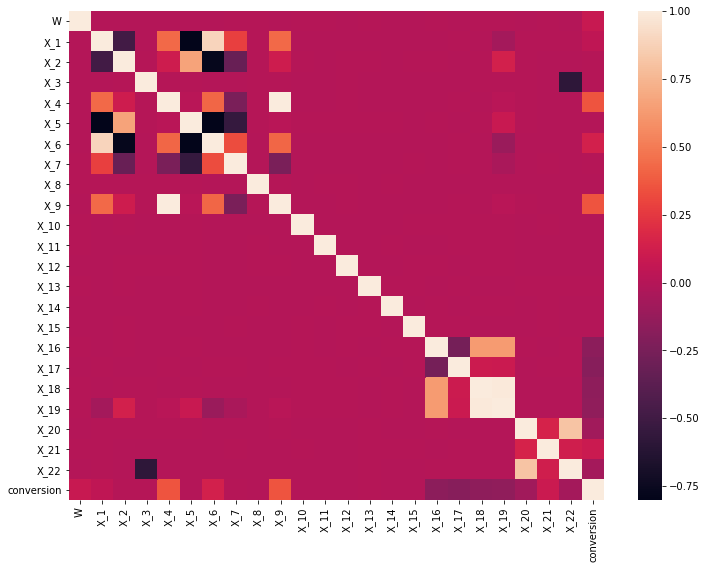

In [62]:
fig = plt.subplots(figsize=(12,9))
sns.heatmap(data3.corr())
plt.show()

Как можно видеть на графике, некоторые фичи сильно коррелируют

<i>Для дальнейшей работы предположим, что соблюдается условие unconfoundedness.

<i>Нулевая гипотеза - treatment не привел к увеличению конверсии <br>
Альтернативная - treatment привел к увеличению конверсии

In [63]:
W0 = data3[data3.W==0.0]['conversion']
W1 = data3[data3.W==1.0]['conversion']

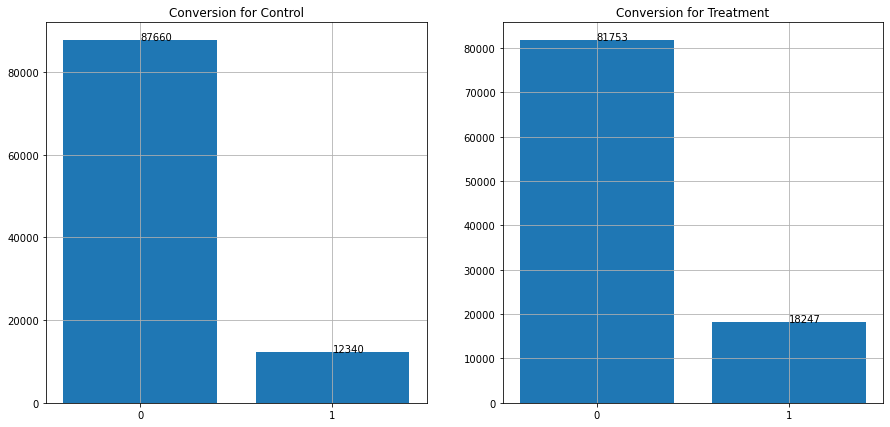

In [64]:
contr = np.array([W0[W0==0].count(),W0[W0==1].count()])
treat = np.array([W1[W1==0].count(),W1[W1==1].count()])
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
ax1.bar(['0','1'], contr)
ax2.bar(['0','1'], treat)

for index, value in enumerate(contr):
    ax1.text(index,value,value)
for index, value in enumerate(treat):
    ax2.text(index,value,value)

ax1.set_title('Conversion for Control')
ax1.grid()    
ax2.set_title('Conversion for Treatment')
ax2.grid()
plt.show()

В качестве статистического критерия используем Хи-квадрат Пирсона.<br>$\alpha$ = 0.05.

In [65]:
W = pd.concat((W1.value_counts().rename('treatment'),W0.value_counts().rename('control')),axis=1).T #contingency матрица
stat, p, dof, expected  = chi2_contingency(W)
print('t-статистика=%.3f \np-value = %.5f' % (stat, p))

t-статистика=1346.273 
p-value = 0.00000


p-value < $\alpha$,<br>отвергаем нулевую гипотезу. Treatment привел к увеличению конверсии


<b> 1.Оценим ATE регрессией

In [66]:
y = data3.conversion
X = data3.iloc[:,0:23]
X = sm.add_constant(X)
model = sm.OLS(y,X)
results = model.fit()

In [67]:
conv=results.params['W']
print('\u03C4_ATE = ',conv)

τ_ATE =  0.0602425239744754


<b> 2.Оценим СATE с помощью S,T и X-Learner'ов.

In [68]:
forest = RandomForestClassifier()
xgb = XGBClassifier()

In [69]:
S_learn = SLearner(forest)
T_learn = TLearner((forest,xgb))
X_learn = XLearner((forest,xgb),cate_models=(forest,xgb), propensity_model=xgb)

In [70]:
X = data3.iloc[:,1:23]
Y = data3.conversion
T = data3.W

S_learn.fit(Y,T,X)
T_learn.fit(Y,T,X)
X_learn.fit(Y,T,X)

cate_s = S_learn.marginal_effect(T.values,X)
cate_t = T_learn.marginal_effect(T.values,X)
cate_x = X_learn.marginal_effect(T.values,X)

D:\Progi\Anaconda\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: X should be passed by keyword only. In a future release we will disallow passing X by position.
  """
D:\Progi\Anaconda\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: X should be passed by keyword only. In a future release we will disallow passing X by position.
  
D:\Progi\Anaconda\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: X should be passed by keyword only. In a future release we will disallow passing X by position.
  import sys


In [71]:
cate_s = pd.Series(cate_s[:,0])
cate_t = pd.Series(cate_t[:,0])
cate_x = pd.Series(cate_x[:,0])

CATE, которые дает XLearner являются нецелочисленными значениями от -1 до 1. Для визуализации приведм все значения к -1,0 и 1 

In [72]:
cate_x_int = cate_x.copy()
cate_x_int[cate_x_int<=-0.3] = -1
cate_x_int[cate_x_int>=0.3] = 1
cate_x_int[(cate_x_int<0.3)&(cate_x_int>-0.3)] = 0

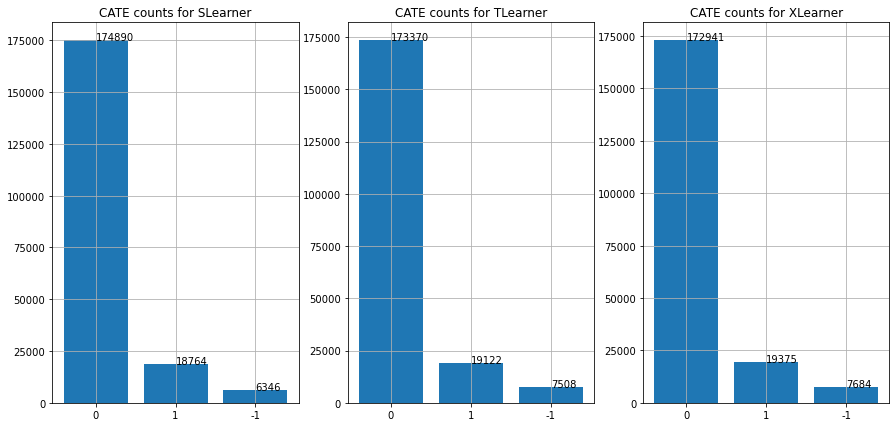

In [73]:
values_s = np.array(cate_s.value_counts())
values_t = np.array(cate_t.value_counts())
values_x = np.array(cate_x_int.value_counts())
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,7))
ax1.bar(['0','1','-1'], values_s)
ax2.bar(['0','1','-1'], values_t)
ax3.bar(['0','1','-1'], values_x)

for index, value in enumerate(values_s):
    ax1.text(index,value,value)
for index, value in enumerate(values_t):
    ax2.text(index,value,value)
for index, value in enumerate(values_x):
    ax3.text(index,value,value)
    
ax1.set_title('CATE counts for SLearner')
ax1.grid()    
ax2.set_title('CATE counts for TLearner')
ax2.grid()
ax3.set_title('CATE counts for XLearner')
ax3.grid()
plt.show()

Как видно из результатов, при использовании XLearner'a сегменты Persuadables(1) и Sleeping Dogs(-1) имеют наибольший размер.

<b>3.Проставьте рекомендации к воздействию на каждый объект.

CATE оценка, равная 1, соответствует сегменту Persuadables. Оценка -1 - это Sleeping Dogs. 0 - это Sure Things И Lost Causes. Нас интересуют только Persuadables, так как только воздействие на них будет иметь эффект.

Соответсвенно занулим все оценки, кроме 1 в результатах SLearner'а и TLearner'a.

SLearner

In [74]:
treatment_s = cate_s
treatment_s[treatment_s!=1] = 0
treatment_s.value_counts()

0    181236
1     18764
dtype: int64

TLearner

In [75]:
treatment_t = cate_t
treatment_t[treatment_t!=1] = 0
treatment_t.value_counts()

0    180878
1     19122
dtype: int64

Для XLearner'а пусть, если оценка >= 0.3, тогда мы оказываем воздействие, остальные случаи зануляем.

In [76]:
treatment_x = cate_x
treatment_x[treatment_x>=0.3] = 1
treatment_x[treatment_x<0.3] = 0

In [77]:
treatment_x.value_counts()

0.0    180625
1.0     19375
dtype: int64

<b>4.Какая ожидаемая конверсия при оптимальном воздействии?

In [78]:
conv_s = treatment_s.sum()/treatment_s.count()*100
conv_t = treatment_t.sum()/treatment_t.count()*100
conv_x = treatment_x.sum()/treatment_x.count()*100
print('Конверсии:','\nSLearner:',round(conv_s,3),'\nTLearner:',round(conv_t,3),'\nXLearner:',round(conv_x,3))

Конверсии: 
SLearner: 9.382 
TLearner: 9.561 
XLearner: 9.688


In [79]:
uplift_conv = conv_x
print('Ожидаемая конверсия при оптимальном воздействии: {} %'.format(round(uplift_conv,3)))

Ожидаемая конверсия при оптимальном воздействии: 9.688 %


In [80]:
print('Конверсия при эксперименте: {} %\nОжидаемая конверсия, которую предсказывает uplift модель: {} %'
      .format(round(conv*100,3),round(uplift_conv,3)))

Конверсия при эксперименте: 6.024 %
Ожидаемая конверсия, которую предсказывает uplift модель: 9.688 %


<i>Таким образом, использование uplift моделирования увеличило конверсию на 3.664 %